# CSC321H5 Project 3 - CNN to predict if shoes are of the pair
Valerie June Loka (100 4900 495) lokavale,
Gabrielle Ong (100 4634 791) onggabr1

**Deadline**: Thursday, March. 19, by 9pm

**Submission**: Submit a PDF export of the completed notebook. 

**Late Submission**: Please see the syllabus for the late submission criteria.

In this assignment, we will build a convolutional neural network that can predict 
whether two shoes are from the **same pair** or from two **different pairs**.
This kind of application can have real-world applications: for example to help
people who are visually impaired to have more independence.

We will explore two convolutional architectures. While we will give you starter
code to help make data processing a bit easier, you'll have a chance to build your
neural network all by yourself!

You may modify the starter code as you see fit, including changing the signatures of
functions and adding/removing helper functions. However, please make sure that your
TA can understand what you are doing and why.

If you find exporting the Google Colab notebook to be difficult, you can create
your own PDF report that includes your code, written solutions, and outputs that
the graders need to assess your work.

In [ ]:
import pandas
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Question 1. Data

Download the data from the course website at https://www.cs.toronto.edu/~lczhang/321/files/p3data.zip

Unzip the file. There are three
main folders: `train`, `test_w` and `test_m`. Data in `train` will be used for
training and validation, and the data in the other folders will be used for testing.
This is so that the entire class will have the same test sets.

We've separated `test_w` and `test_m` so that we can track our model performance 
for women's shoes and men's shoes separately. Each of the test sets contain images
from 10 students who submitted images of either exclusively men's shoes or women's
shoes.

Upload this data to Google Colab.
Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


After you have done so, read this entire section (ideally this entire handout)
before proceeding. There are right and wrong ways of
processing this data. If you don't make the correct choices, you may find
yourself needing to start over.
Many machine learning projects fail because of the lack of care taken during
the data processing stage.

### Part (a) -- 1 pts

Why might we care about the accuracies of the men's and women's shoes as two
separate measures? Why would we expect our model accuracies for the two groups
to be different?

Recall that your application may help people who are visually impaired.

In [ ]:
# Your answer goes here. Please make sure it is not cut off
"""
the measurements between men's and women's shoes are typically different by size
and shape. Thus, we want them to be in 2 separate measures such that the model
won't misclassify a men's shoe with another women's shoe to be in a
pair. The model accuracies would be different due to the ratio of men's shoes
compared to women's shoes that were in the training dataset for the model to
train on.
"""

"\nthe measurements between men's and women's shoes are typically different by size\nand shape. Thus, we want them to be in 2 separate measures such that the model\nwon't misclassify a men's shoe with another women's shoe to be in a\npair. The model accuracies would be different due to the ratio of men's shoes\ncompared to women's shoes that were in the training dataset for the model to\ntrain on.\n"

### Part (b) -- 4 pts

Load the training and test data, and separate your training data into training and validation.
Create the numpy arrays `train_data`, `valid_data`, `test_w` and `test_m`, all of which should
be of shape `[*, 3, 2, 224, 224, 3]`. The dimensions of these numpy arrays are as follows:

- `*` - the number of students allocated to train, valid, or test
- `3` - the 3 pairs of shoes submitted by that student
- `2` - the left/right shoes
- `224` - the height of each image
- `224` - the width of each image
- `3` - the colour channels

So, the item `train_data[4,0,0,:,:,:]` should give us the left shoe of the first image submitted
by the 5th student.The item `train_data[4,0,1,:,:,:]`  should be the right shoe in the same pair. 
The item `train_data[4,1,1,:,:,:]`  should be the right shoe in a different pair, submitted by
the same student.

When you first load the images using (for example) `plt.imread`, you may see a numpy array of shape
`[224, 224, 4]` instead of `[224, 224, 3]`. That last channel is the alpha channel for transparent
pixels, and should be removed. 
The pixel intensities are stored as an integer between 0 and 255.
Divide the intensities by 255 so that you have floating-point values between 0 and 1. Then, subtract 0.5
so that the elements of `train_data`, `valid_data` and `test_data` are between -0.5 and 0.5.
**Note that this step actually makes a huge difference in training!**

This function might take a while to run---it takes 3-4 minutes for me to just
load the files from Google Drive.  If you want to avoid
running this code multiple times, you can save 
your numpy arrays and load it later:
https://docs.scipy.org/doc/numpy/reference/generated/numpy.save.html

In [ ]:
# Your code goes here. Make sure it does not get cut off
# You can use the code below to help you get started. You're welcome to modify
# the code or remove it entirely: it's just here so that you don't get stuck
# reading files

import glob

def create_dict(path):
  d = {}
  for file in glob.glob(path):
    filename = file.split("/")[-1]   # get the name of the .jpg file
    img = plt.imread(file)           # read the image as a numpy array
    d[filename] = img[:, :, :3] # remove the alpha channel
  return d

def create_names_list(data_dict):
  """
  this function creates the sorted array of names of files for that data.
  """
  l = []
  for key in data_dict:
    l.append(key)
  l.sort()
  return l

def create_array_data(names_list, data_dict):
  """
  this function creates the desired array to represent the data.
  """
  student_amount = int(len(names_list) / 6)
  data_arr = np.ones((student_amount, 3, 2, 224, 224, 3))
  i = 0
  i_data = 0
  while i <= len(names_list) - 6:
    set = names_list[i: i+6]
    for im in set:
      if "left" in im:
        if "_1_" in im:
          data_arr[i_data,0,0,:,:,:] = data_dict[names_list[i]]
        elif "_2_" in im:
          data_arr[i_data,1,0,:,:,:] = data_dict[names_list[i]]
        elif "_3_" in im:
          data_arr[i_data,2,0,:,:,:] = data_dict[names_list[i]]

      elif "right" in im:
        if "_1_" in im:
          data_arr[i_data,0,1,:,:,:] = data_dict[names_list[i]]
        elif "_2_" in im:
          data_arr[i_data,1,1,:,:,:] = data_dict[names_list[i]]
        elif "_3_" in im:
          data_arr[i_data,2,1,:,:,:] = data_dict[names_list[i]]

      i += 1
    i_data += 1
  return (data_arr/255) - 0.5




# Load numpy arrays
test_m = np.load('/content/gdrive/My Drive/CSC321/data/test_m.npy')
test_w = np.load('/content/gdrive/My Drive/CSC321/data/test_w.npy')
total_data = np.load('/content/gdrive/My Drive/CSC321/data/total_data.npy')

train_data = total_data[:68]
valid_data = total_data[68:]

(224, 224, 3)


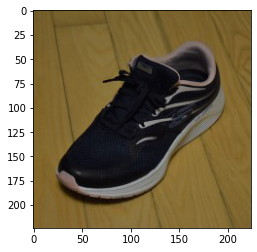

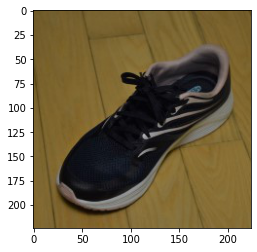

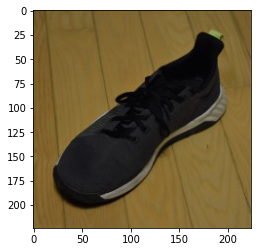

In [ ]:
# Run this code, include the image in your PDF submission
plt.figure()
plt.imshow(train_data[60,0,0,:,:,:]+.5) 
# left shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[60,0,1,:,:,:]+.5) 
# right shoe of first pair submitted by 5th student
plt.figure()
plt.imshow(train_data[60,1,1,:,:,:]+.5) 
# right shoe of second pair submitted by 5th student
print(train_data[4,1,1,:,:,:].shape)

### Part (c) -- 2 pts

Since we want to train a model that determines whether two shoes come from the **same**
pair or **different** pairs, we need to create some labelled training data.
Our model will take in an image, either consisting of two shoes from the **same pair**
or from **different pairs**. So, we'll need to generate some *positive examples* with
images containing two shoes that *are* from the same pair, and some *negative examples* where 
images containing two shoes that *are not* from the same pair.
We'll generate the *positive examples* in this part, and the *negative examples* in part (c).

Write a function `generate_same_pair()` that takes one of the data sets that you produced
in part (a), and generates a numpy array where each pair of shoes in the data set is
concatenated together. In particular, we'll be concatenating together images of left
and right shoes along the **height** axis. Your function `generate_same_pair` should
return a  numpy array of shape `[*, 448, 224, 3]`.

(Later on, we will need to convert this numpy array into a PyTorch tensor with shape
`[*, 3, 448, 224]`. For now, we'll keep the RGB channel as the last dimension since
that's what `plt.imshow` requires)

(68, 3, 2, 224, 224, 3)
(204, 448, 224, 3)


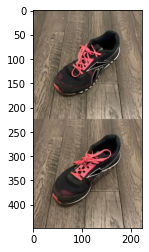

In [ ]:
# Your code goes here
def generate_same_pair(data):
  N = len(data)
  return data.reshape(N*3, 448, 224, 3)



# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_same_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_same_pair(train_data)[2] + 0.5) 
# should show 2 shoes from the same pair
# added 0.5 to brighten image

### Part (d) -- 2 pts

Write a function `generate_different_pair()` that takes one of the data sets that
you produced in part (a), and generates a numpy array in the same shape as part (b).
However, each image will contain 2 shoes from a **different** pair, but submitted
by the **same student**. Do this by jumbling the 3 pairs of shoes submitted by 
each student.

Theoretically, for each student image submissions, there are 6 different combinations
of "wrong pairs" that we could produce. To keep our data set *balanced*, we will
only produce **three** combinations of wrong pairs per unique person.
In other words,`generate_same_pairs` and `generate_different_pairs` should
return the same number of training examples.

(68, 3, 2, 224, 224, 3)
(204, 448, 224, 3)


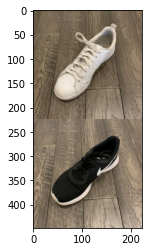

In [ ]:
# Your code goes here
def generate_different_pair(data):
  N = len(data)
  fake = np.copy(data)
  fake[:,0,0,:,:,:], fake[:,1,1,:,:,:] = fake[:,1,1,:,:,:], fake[:,0,0,:,:,:]
  fake[:,1,0,:,:,:], fake[:,2,1,:,:,:] = fake[:,2,1,:,:,:], fake[:,1,0,:,:,:]

  
  fake[:,2,0,:,:,:], fake[:,0,1,:,:,:] = fake[:,0,1,:,:,:], fake[:,2,0,:,:,:]
  return fake.reshape(N*3, 448, 224, 3) # NWHC

# Run this code, include the result with your PDF submission
print(train_data.shape) # if this is [N, 3, 2, 224, 224, 3]
print(generate_different_pair(train_data).shape) # should be [N*3, 448, 224, 3]
plt.imshow(generate_different_pair(train_data)[0] + 0.5) 
# should show 2 shoes from different pairs

### Part (e) -- 1 pts

Why do we insist that the different pairs of shoes still come from the same
student?  (Hint: what else do images from the same student have in common?)

In [ ]:
# Your answer goes here. Please make sure it is not cut off
"""
we need the different pairs of shoes images to have the same backgrounds.
If the different pairs of shoes have different backgrounds, the model might
identify the different backgrounds, and by that conclude that the shoes are from
different pairs.
"""

'\nwe need the different pairs of shoes images to have the same backgrounds.\nIf the different pairs of shoes have different backgrounds, the model might\nidentify the different backgrounds, and by that conclude that the shoes are from\ndifferent pairs.\n'

### Part (f) -- 1 pts

Why is it important that our data set be *balanced*? In other words suppose we created
a data set where 99% of the images are of shoes that are *not* from the same pair, and 
1% of the images are shoes that *are* from the same pair. Why could this be a problem?

In [ ]:
# Your answer goes here. Please make sure it is not cut off



"""
The data will be skewed and the model will be biased towards
identifying shoes that are not from the same pair, and not the same shoes.
"""

'\nThe data will be skewed and the model will be biased towards being able to\nidentify different shoes and not the same shoes.\n'

## Question 2. Convolutional Neural Networks

Before starting this question, we recommend reviewing the lecture and tutorial materials
on convolutional neural networks.

In this section, we will build two CNN models in PyTorch.

### Part (a) -- 4 pts

Implement a CNN model in PyTorch called `CNN` that will take images of size
$3 \times 448 \times 224$, and classify whether the images contain shoes from
the same pair or from different pairs.

The model should contain the following layers:

- A convolution layer that takes in 3 channels, and outputs $n$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A second convolution layer that takes in $n$ channels, and outputs $n \times 2$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A third convolution layer that takes in $n \times 2$ channels, and outputs $n \times 4$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fourth convolution layer that takes in $n \times 4$ channels, and outputs $n \times 8$ channels.
- A $2 \times 2$ downsampling (either using a strided convolution in the previous step, or max pooling)
- A fully-connected layer with 100 hidden units
- A fully-connected layer with 2 hidden units

Make the variable $n$ a parameter of your CNN. You can use either $3 \times 3$ or $5 \times 5$
convolutions kernels. Set your padding to be `(kernel_size - 1) / 2` so that your feature maps
have an even height/width.

Note that we are omitting certain steps that practitioners will typically not mention,
like ReLU activations and reshaping operations. Use the tutorial materials and your
past projects to figure out where they are.

In [ ]:
class CNN(nn.Module):
    def __init__(self, n=4):
        super(CNN, self).__init__()
        # TODO: complete this method
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(n)
        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=n*2,
                               kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(n*2)
        self.conv3 = nn.Conv2d(in_channels=n*2,
                               out_channels=n*4,
                               kernel_size=3,
                               padding=1)
        self.bn3 = nn.BatchNorm2d(n*4)
        self.conv4 = nn.Conv2d(in_channels=n*4,
                               out_channels=n*8,
                               kernel_size=3,
                               padding=1)
        self.bn4 = nn.BatchNorm2d(n*8)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(n*8 * 28 * 14, 100)
        self.fc2 = nn.Linear(100, 2)

    # TODO: complete this class
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.bn3(x)
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.bn4(x)
        x = x.view(-1, self.n*8 * 28 * 14)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

### Part (b) -- 4 pts

Implement a CNN model in PyTorch called `CNNChannel` that contains the same layers as
in the Part (a), but with one crucial difference: instead of starting with an image
of shape $3 \times 448 \times 224$, we will first manipulate the image so that the
left and right shoes images are concatenated along the **channel** dimension.

<img src="https://www.cs.toronto.edu/~lczhang/321/hw/p3model.png" width="400px" />

Complete the manipulation in the `forward()` method (by slicing and using
the function `torch.cat`). The input to the first convolutional layer
should have 6 channels instead of 3 (input shape $6 \times 224 \times 224$).

Use the same hyperparameter choices as you did in part (a), e.g. for the kernel size,
choice of downsampling, and other choices.

In [ ]:
class CNNChannel(nn.Module):
    def __init__(self, n=4):
        super(CNNChannel, self).__init__()
        # TODO: complete this method
        self.n = n
        self.conv1 = nn.Conv2d(in_channels=6,
                               out_channels=n,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(n)
        self.conv2 = nn.Conv2d(in_channels=n,
                               out_channels=n*2,
                               kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(n*2)
        self.conv3 = nn.Conv2d(in_channels=n*2,
                               out_channels=n*4,
                               kernel_size=3,
                               padding=1)
        self.bn3 = nn.BatchNorm2d(n*4)
        self.conv4 = nn.Conv2d(in_channels=n*4,
                               out_channels=n*8,
                               kernel_size=3,
                               padding=1)
        self.bn4 = nn.BatchNorm2d(n*8)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(n*8 * 14 * 14, 100)
        self.fc2 = nn.Linear(100, 2)

    # TODO: complete this class
    def forward(self, x):
        a = x[:, :, :, :224]
        b = x[:, :, :, 224:]
        x = torch.cat((a, b), axis=1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.bn3(x)
        x = self.pool(torch.relu(self.conv4(x)))
        x = self.bn4(x)
        x = x.view(-1, self.n*8 * 14 * 14)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

## Part (c) -- 2 pts

Although our task is a binary classification problem, we will still use the architecture
of a multi-class classification problem. That is, we'll use a one-hot vector to represent
our target (just like in Project 2). We'll also use `CrossEntropyLoss` instead of
`BCEWithLogitsLoss`. In fact, this is a standard practice in machine learning because
this architecture performs better!

Explain why this architecture might give you better performance.

In [ ]:
# Your answer goes here. Please make sure it is not cut off
"""
BCEWithLogitsLoss includes the sigmoid function, while CrossEntropyLoss includes
the softmax function. When using a softmax, a probability of each class whose 
sum is bound to be one is obtained. In case of using sigmoid, it’d be like a 
Bernoulli likelihood. Using CrossEntropyLoss will give better performance, 
because we would obtain a probability distribution of classification among
same pairs of men and women shoes, and different pairs of men and women shoes.
"""

'\n\n'

## Part (d) -- 2 pts

The two models are quite similar, and should have almost the same number of parameters.
However, one of these models will perform better, showing that architecture choices **do**
matter in machine learning. Explain why one of these models performs better.

In [ ]:
# Your answer goes here. Please make sure it is not cut off
"""
My hypothesis is that the CNNChannel model will perform better, since the images
are layered on top of each other, direct comparison of different positions on
the images can be made more easily.
Whereas for the CNN model, images are put side by side, which might make
comparing harder, since the model would need to perform some sort of mapping on
the different corresponding regions on the 2 images.
"""

## Part (e) -- 2 pts

The function `get_accuracy` is written for you. You may need to modify this
function depending on how you set up your model and training.

Unlike in project 2, we will separately compute the model accuracy on the
positive and negative samples.  Explain why we may wish to track these
two values separately.

In [ ]:
# Your answer goes here. Please make sure it is not cut off
"""
We wish to track these two values separately because it is good practice since
we can see how our model perforrms on new unseen data.
Also, this way we can observe how well the model classifies each type of cases,
which can lead to concluding too how efficient and well designed our model is.
"""

In [ ]:
def get_accuracy(model, data, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    model.eval()
    n = data.shape[0]

    data_pos = generate_same_pair(data) # should have shape [n * 3, 448, 224, 3]
    data_neg = generate_different_pair(data) 
    # should have shape [n * 3, 448, 224, 3]

    pos_correct = 0
    for i in range(0, len(data_pos), batch_size):
        xs = torch.Tensor(data_pos[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len(data_neg), batch_size):
        xs = torch.Tensor(data_neg[i:i+batch_size]).transpose(1, 3)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct / (n * 3), neg_correct / (n * 3)

## Question 3. Training

Now, we will write the functions required to train the model.

### Part (a) -- 10 pts

Write the function `train_model` that takes in (as parameters) the model, training data,
validation data, and other hyperparameters like the batch size, weight decay, etc.
This function should be somewhat similar to the training code that you wrote
in Project 2, but with a major difference in the way we treat our training data.

Since our positive and negative training sets are separate, it is actually easier for
us to generate separate minibatches of positive and negative training data! In
each iteration, we'll take `batch_size / 2` positive samples and `batch_size / 2`
negative samples. We will also generate labels of 1's for the positive samples,
and 0's for the negative samples.

Here's what we will be looking for:

- main training loop; choice of loss function; choice of optimizer
- obtaining the positive and negative samples
- shuffling the positive and negative samples at the start of each epoch
- in each iteration, take `batch_size / 2` positive samples and `batch_size / 2` negative samples
  as our input for this batch
- in each iteration, take `np.ones(batch_size / 2)` as the labels for the positive samples, and 
  `np.zeros(batch_size / 2)` as the labels for the negative samples
- conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions "NCHW",
  use the `.transpose()` method in either PyTorch or numpy
- computing the forward and backward passes
- after every epoch, checkpoint your model (Project 2 has in-depth instructions and examples for how to do this)
- after every epoch, report the accuracies for the training set and validation set
- track the training curve information and plot the training curve

In [ ]:
# Write your code here
# generate_same_pair, generate_different_pair
def train_model(model, train_data, valid_data, batch_size=0, weight_decay=0.0,
          learning_rate=0.0, num_epochs=0, checkpoint_path=None):
    
    # training data
    positive_data = generate_same_pair(train_data)
    negative_data = generate_different_pair(train_data)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations (for plotting)
    for epoch in range(num_epochs):
        np.random.shuffle(positive_data)
        np.random.shuffle(negative_data)
        for i in range(0, positive_data.shape[0], batch_size//2):
          if (i + batch_size//2) > positive_data.shape[0]:
            continue

          # NWHC to NCHW
          pos_xs = torch.Tensor(positive_data[i:i+batch_size//2]).transpose(1,3)
          neg_xs = torch.Tensor(negative_data[i:i+batch_size//2]).transpose(1,3)
          imgs = torch.cat((pos_xs, neg_xs), axis=0)
          pos_labels = np.ones(batch_size // 2)
          neg_labels = np.zeros(batch_size // 2)
          labels = np.concatenate((pos_labels, neg_labels), axis=0)
          labels = torch.Tensor(labels).long()

          model.train()
          out = model(imgs)
          loss = criterion(out, labels)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          n += 1

        # save the current training information
        loss = float(loss)/batch_size
        tacc = get_accuracy(model, train_data)
        vacc = get_accuracy(model, valid_data)
        print("Iter %d; Loss %f; Train Pos Acc %.3f; Train Neg Acc %.3f; \
        Val Pos Acc %.3f; Val Neg Acc %.3f" % (n, loss, tacc[0], tacc[1], 
                                               vacc[0], vacc[1]))



        iters.append(n)
        losses.append(loss)
        train_acc.append(tacc)
        val_acc.append(vacc)

        if (checkpoint_path is not None) and n > 0:
                    torch.save(model.state_dict(), checkpoint_path.format(n))

    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) -- 2 pts

Sanity check your code from Q3(a) and from Q2(a) and Q2(b) by showing that your models
can memorize a very small subset of the training set (e.g. 5 images).
You should be able to achieve 90%+ accuracy
relatively quickly (within ~30 or so iterations).

(If you have trouble with CNN() but not CNNChannel(), try reducing $n$, e.g. try working
with the model `CNN(2)`)

Iter 7; Loss 0.181116; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 14; Loss 0.025083; Train Pos Acc 0.000; Train Neg Acc 1.000;         Val Pos Acc 0.000; Val Neg Acc 1.000
Iter 21; Loss 0.117556; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 28; Loss 0.051767; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 35; Loss 0.059039; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 42; Loss 0.013398; Train Pos Acc 1.000; Train Neg Acc 0.267;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 49; Loss 0.011625; Train Pos Acc 0.933; Train Neg Acc 0.600;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 56; Loss 0.013233; Train Pos Acc 0.933; Train Neg Acc 0.800;         Val Pos Acc 1.000; Val Neg Acc 0.200
Iter 63; Loss 0.001341; Train Pos Acc 0.933; Train Neg Acc 0.733;         Val Pos Acc 1.000; Val Neg Acc 0.133
It

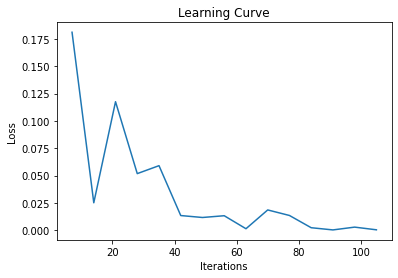

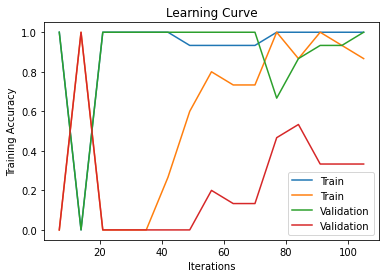

Final Training Accuracy: (1.0, 0.8666666666666667)
Final Validation Accuracy: (1.0, 0.3333333333333333)
-------------------------
Iter 7; Loss 0.214410; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 14; Loss 0.264719; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 21; Loss 0.012807; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 28; Loss 0.009267; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 35; Loss 0.002623; Train Pos Acc 1.000; Train Neg Acc 0.067;         Val Pos Acc 1.000; Val Neg Acc 0.133
Iter 42; Loss 0.006157; Train Pos Acc 1.000; Train Neg Acc 0.333;         Val Pos Acc 1.000; Val Neg Acc 0.467
Iter 49; Loss 0.000099; Train Pos Acc 1.000; Train Neg Acc 0.467;         Val Pos Acc 1.000; Val Neg Acc 0.600
Iter 56; Loss 0.001295; Train Pos Acc 1.000; Train Neg Acc 0.600;         Val Pos Acc 1.000; V

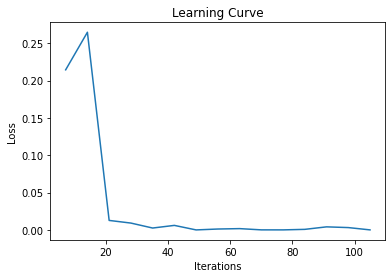

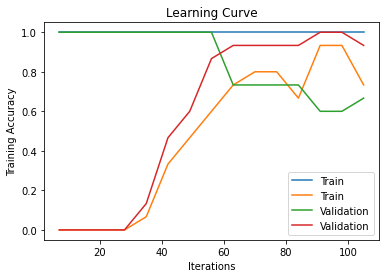

Final Training Accuracy: (1.0, 0.7333333333333333)
Final Validation Accuracy: (0.6666666666666666, 0.9333333333333333)


In [ ]:
# Write your code here. Remember to include your results so that your TA can
# see that your model atains a high validation accuracy.
cnn_model = CNN()
cnn_channel_model = CNNChannel()
cnn_train = train_model(cnn_model, train_data[:5], valid_data[:5], batch_size=5, 
                  weight_decay=0.0, learning_rate=0.001, num_epochs=15)
print("-------------------------")
cnn_channel_train = train_model(cnn_channel_model, valid_data[:5], 
                                train_data[:5], batch_size=5, weight_decay=0.0, 
                                learning_rate=0.001, num_epochs=15)

### Part (c) -- 4 pts

Train your models from Q2(a) and Q2(b). You will want to explore the effects of a few 
hyperparameters, including the learning rate, batch size, choice of $n$, and potentially
the kernel size. You do not need to check all values for all hyperparameters. Instead,
get an intuition about what each of the parameters do.

In this section, explain how you tuned your hyperparameters.

Iter 13; Loss 0.015476; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 26; Loss 0.010115; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 39; Loss 0.007660; Train Pos Acc 1.000; Train Neg Acc 0.181;         Val Pos Acc 1.000; Val Neg Acc 0.008
Iter 52; Loss 0.005979; Train Pos Acc 1.000; Train Neg Acc 0.578;         Val Pos Acc 0.992; Val Neg Acc 0.227
Iter 65; Loss 0.002540; Train Pos Acc 0.995; Train Neg Acc 0.784;         Val Pos Acc 0.977; Val Neg Acc 0.386
Iter 78; Loss 0.000949; Train Pos Acc 0.985; Train Neg Acc 0.892;         Val Pos Acc 0.977; Val Neg Acc 0.477
Iter 91; Loss 0.000649; Train Pos Acc 1.000; Train Neg Acc 0.941;         Val Pos Acc 0.977; Val Neg Acc 0.477
Iter 104; Loss 0.000477; Train Pos Acc 1.000; Train Neg Acc 0.828;         Val Pos Acc 0.992; Val Neg Acc 0.417
Iter 117; Loss 0.000302; Train Pos Acc 1.000; Train Neg Acc 0.936;         Val Pos Acc 0.977; Val Neg Acc 0.515

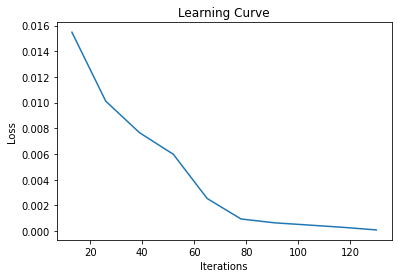

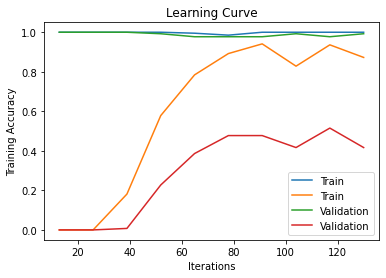

Final Training Accuracy: (1.0, 0.8725490196078431)
Final Validation Accuracy: (0.9924242424242424, 0.4166666666666667)
-------------------------
Iter 13; Loss 0.020638; Train Pos Acc 1.000; Train Neg Acc 0.000;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 26; Loss 0.010855; Train Pos Acc 1.000; Train Neg Acc 0.132;         Val Pos Acc 1.000; Val Neg Acc 0.000
Iter 39; Loss 0.010637; Train Pos Acc 1.000; Train Neg Acc 0.314;         Val Pos Acc 1.000; Val Neg Acc 0.023
Iter 52; Loss 0.002713; Train Pos Acc 1.000; Train Neg Acc 0.598;         Val Pos Acc 0.992; Val Neg Acc 0.167
Iter 65; Loss 0.001697; Train Pos Acc 0.995; Train Neg Acc 0.863;         Val Pos Acc 0.962; Val Neg Acc 0.417
Iter 78; Loss 0.000885; Train Pos Acc 1.000; Train Neg Acc 0.843;         Val Pos Acc 0.985; Val Neg Acc 0.250
Iter 91; Loss 0.000879; Train Pos Acc 1.000; Train Neg Acc 0.858;         Val Pos Acc 0.985; Val Neg Acc 0.333
Iter 104; Loss 0.000735; Train Pos Acc 1.000; Train Neg Acc 0.931;         Val

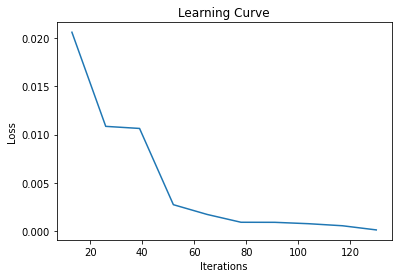

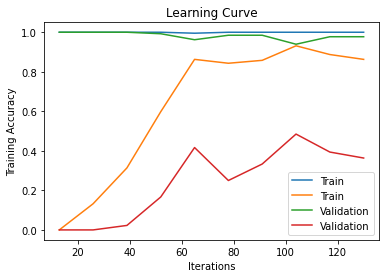

Final Training Accuracy: (1.0, 0.8627450980392157)
Final Validation Accuracy: (0.9772727272727273, 0.36363636363636365)


In [ ]:
# Include the training curves for the two models.
cnn_model = CNN()
cnn_channel_model = CNNChannel()
cnn_train = train_model(cnn_model, train_data, valid_data, batch_size=30, 
                  weight_decay=0.0, learning_rate=0.001, num_epochs=10, 
          checkpoint_path='gdrive/My Drive/CSC321/proj3/mlp_1/ckpt-{}.pk')
print("-------------------------")




cnn_channel_train = train_model(cnn_channel_model, train_data, valid_data, 
            batch_size=30, weight_decay=0.0, learning_rate=0.001, num_epochs=10, 
          checkpoint_path='gdrive/My Drive/CSC321/proj3/mlp_2/ckpt-{}.pk')

"""
HOW DID I TUNE MY HYPERPARAMETERS?

I frequently made changes to the num_epochs and batch_size.

Decreasing the num_epochs when I noticed that having a large number will cause 
the accuracy to increase, and then decrease. 
And increasing num_epochs when I noticed the accuracy can still be improved.

I tried to set batch_size to a reasonable number such that training the model
won't take too long, or over generalize too much. To do this, I just reduced and
increased batch_size a little, not much less than or equal to 30. And I just
alternated that with respect to how high the accuracies can be achieved.
"""

### Part (d) -- 2 pts

Include your training curves for the **best** models from each of Q2(a) and Q2(b).
These are the models that you will use in Question 4.

In [ ]:
# Include the training curves for the two models.
# See training curves in Q3 b)


## Question 4.

### Part (a) -- 3 pts

Report the test accuracies of your **single best** model,
separately for the two test sets.
Do this by choosing the checkpoint of the model
architecture that produces the best validation accuracy. That is,
if your model attained the
best validation accuracy in epoch 12, then the weights at epoch 12 is what you should be using
to report the test accuracy.

In [ ]:
# Write your code here. Make sure to include the test accuracy in your report
cnn_model.load_state_dict(torch.load('gdrive/My Drive/CSC321/proj3/mlp_1/\
ckpt-117.pk'))
cnn_channel_model.load_state_dict(torch.load('gdrive/My Drive/CSC321/proj3/mlp_2\
/ckpt-104.pk'))



print("Men: (positive acc, negative acc): ", get_accuracy(cnn_model, test_m))
print("Women: (positive acc, negative acc): ", get_accuracy(cnn_model, test_w))

Men: (positive acc, negative acc):  (1.0, 0.5)
Women: (positive acc, negative acc):  (0.9333333333333333, 0.5)


### Part (b) -- 2 pts

Display one set of men's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the men's shoes test set,
display one set of inputs that your model classified incorrectly.

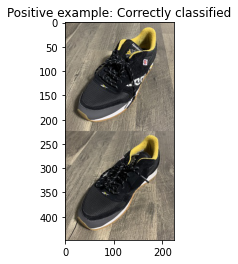

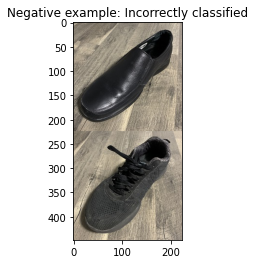

In [ ]:
# call argmax on the prediction
# display first image that's positive/negative

data_pos = generate_same_pair(test_m)
data_neg = generate_different_pair(test_m)
is_shown_correct = False
is_shown_incorrect = False
for i in range(0, len(data_pos), 1):
    if is_shown_correct and is_shown_incorrect:
        break
    xs_pos = torch.Tensor(data_pos[i:i+1]).transpose(1, 3)
    xs_neg = torch.Tensor(data_neg[i:i+1]).transpose(1, 3)
    zs_pos = cnn_model(xs_pos)
    zs_neg = cnn_model(xs_neg)
    pred_pos = zs_pos.max(1, keepdim=True)[1] # get the index of the max logit
    pred_neg = zs_neg.max(1, keepdim=True)[1] # get the index of the max logit
    pred_pos = pred_pos.detach().numpy()
    pred_neg = pred_neg.detach().numpy()
    if pred_pos == 1 and is_shown_correct == False:
        plt.figure()
        plt.imshow(data_pos[i]+0.5) # add 0.5 to brighten image
        plt.title("Positive example: Correctly classified")
        is_shown_correct = True
    elif pred_pos == 0 and is_shown_incorrect == False:
        plt.figure()
        plt.imshow(data_neg[i]+0.5) # add 0.5 to brighten image
        plt.title("Positive example: Incorrectly classified")
        is_shown_incorrect = True
    elif pred_neg == 1 and is_shown_incorrect == False:
        plt.figure()
        plt.imshow(data_neg[i]+0.5) # add 0.5 to brighten image
        plt.title("Negative example: Incorrectly classified")
        is_shown_incorrect = True
    else:
      continue
        

### Part (c) -- 2 pts

Display one set of women's shoes that your model correctly classified as being
from the same pair.

If your test accuracy was not 100% on the women's shoes test set,
display one set of inputs that your model classified incorrectly.

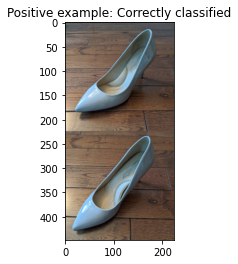

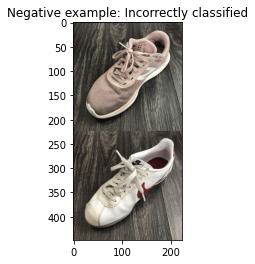

In [ ]:
data_pos = generate_same_pair(test_w)
data_neg = generate_different_pair(test_w)
is_shown_correct = False
is_shown_incorrect = False
for i in range(0, len(data_pos), 1):
    if is_shown_correct and is_shown_incorrect:
        break
    xs_pos = torch.Tensor(data_pos[i:i+1]).transpose(1, 3)
    xs_neg = torch.Tensor(data_neg[i:i+1]).transpose(1, 3)
    zs_pos = cnn_model(xs_pos)
    zs_neg = cnn_model(xs_neg)
    pred_pos = zs_pos.max(1, keepdim=True)[1] # get the index of the max logit
    pred_neg = zs_neg.max(1, keepdim=True)[1] # get the index of the max logit
    pred_pos = pred_pos.detach().numpy()
    pred_neg = pred_neg.detach().numpy()
    if pred_pos == 1 and is_shown_correct == False:
        plt.figure()
        plt.imshow(data_pos[i]+0.5) # add 0.5 to brighten image
        plt.title("Positive example: Correctly classified")
        is_shown_correct = True
    elif pred_pos == 0 and is_shown_incorrect == False:
        plt.figure()
        plt.imshow(data_neg[i]+0.5) # add 0.5 to brighten image
        plt.title("Positive example: Incorrectly classified")
        is_shown_incorrect = True
    elif pred_neg == 1 and is_shown_incorrect == False:
        plt.figure()
        plt.imshow(data_neg[i]+0.5) # add 0.5 to brighten image
        plt.title("Negative example: Incorrectly classified")
        is_shown_incorrect = True
    else:
      continue